# LSTM Stock Predictor Using Closing Prices

In this notebook, a custom LSTM RNN model is built and trained that uses a 3 day window of closing prices of Pharcameutical companies to predict the 4th day closing price. 

Summary of steps:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model


## 1. Data Preparation

In [4]:
# Imports
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
# Set the random seed for reproducibility
#Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [7]:
# Load the closing prices 
file_path = Path('Data/df.csv')
df = pd.read_csv(file_path)
df = df.drop([1])
df.head()

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
0,Symbols,GSK,PFE,AZN,GSK,PFE,AZN
2,1/2/2018,9465500,16185800,6107400,32.10053253,32.92734146,31.99385643
3,1/3/2018,6600800,13456500,4195400,31.97884941,33.1713028,32.05715179
4,1/4/2018,5206400,12378100,3870900,32.03968811,33.24359894,32.1023674
5,1/5/2018,7250700,12492900,3336000,32.60468292,33.30685043,32.43695831


In [8]:

def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close],
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2020-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df

In [9]:
# extract data for GSk and create a dataframe for GSk
gsk_df = construct_df(df, "Volume","Adj Close")
gsk_df.head()

,Volume,Adj Close
Date,,
2020-01-02,2462400.0,45.229774
2020-01-03,2149100.0,44.805626
2020-01-06,2034500.0,44.824902
2020-01-07,1718900.0,44.545349
2020-01-08,1766700.0,44.738148


In [10]:
gsk_df.count()

Volume       186
Adj Close    186
dtype: int64

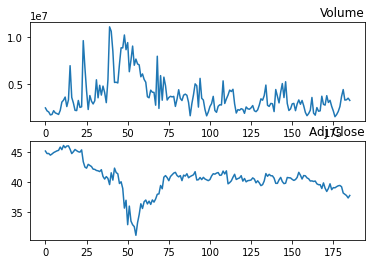

In [11]:

from matplotlib import pyplot

# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(gsk_df.values[:, group])
    pyplot.title(gsk_df.columns[group], loc='right')
    i += 1
pyplot.show()

In [12]:
# extract data for PFE and create a dataframe for PFE
pfe_df = construct_df(df, "Volume.1","Adj Close.1")
pfe_df.head()


,Volume,Adj Close
Date,,
2020-01-02,15668000.0,37.990608
2020-01-03,14158300.0,37.786774
2020-01-06,14963900.0,37.738239
2020-01-07,19077900.0,37.612064
2020-01-08,15563100.0,37.912960


In [13]:
# extract data for AZN and create a dataframe for AZN
azn_df = construct_df(df, "Volume.2","Adj Close.2")
azn_df.head()

,Volume,Adj Close
Date,,
2020-01-02,3587300.0,48.992023
2020-01-03,1208700.0,48.700348
2020-01-06,1992300.0,48.496174
2020-01-07,1871900.0,48.680901
2020-01-08,1869000.0,48.564232


In [14]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Predict closing Prices for PFE using LSTM

In [15]:
# # Predict Closing Prices using a 3 day window of previous closing prices
# # Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 0 is the 'Volume' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(pfe_df, window_size, feature_column, target_column)

In [16]:
# # Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [17]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


In [18]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.02568059]
  [0.        ]
  [0.00617222]]

 [[0.        ]
  [0.01370357]
  [0.07668733]]

 [[0.01370357]
  [0.08368431]
  [0.01644267]]] 

X_test sample values:
[[[0.20416616]
  [0.17908555]
  [0.16792248]]

 [[0.17908555]
  [0.16792248]
  [0.11917611]]

 [[0.16792248]
  [0.11917611]
  [0.17045786]]]


## Build and Train the LSTM RNN

In this section, custom LSTM RNN is built and fit (trained) using the training data.

1. Define the model architecture
2. Compile the model
3. Fit the model to the training data



In [19]:
# Build the LSTM model. 
# The return sequences need to be set to True when adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [20]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 3, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [22]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.3112
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1361
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0895
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0840
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0706
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0544
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0539
Epoch 8/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0475
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0442
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0403
Epoch 11/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0423
Epoch 12/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0342
Epoch 13/20
32/32 [==============================

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Note
Apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [23]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.0684


0.0684317797422409

In [24]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [25]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = pfe_df.index[-len(real_prices): ]) 
stocks.head()


,Real,Predicted
Date,,
2020-07-10,33.136139,36.890076
2020-07-13,33.502560,37.003834
2020-07-14,34.869198,37.083702
2020-07-15,34.889004,36.944878
2020-07-16,35.374264,36.362896


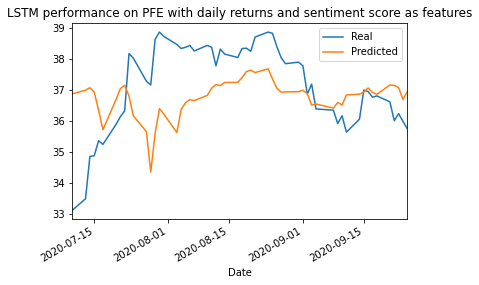

In [27]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 4
stocks.plot(title="LSTM performance on PFE with daily returns and sentiment score as features")
plt.savefig('./Images/LSTMmodel_PFE_returns_sentiment.png')

## Predict Closing prices for GSK using LSTM

In [28]:
###GSK###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 0 is the 'volume' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(gsk_df, window_size, feature_column, target_column)

In [29]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [30]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [31]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.08883128]
  [0.05581724]
  [0.04374124]]

 [[0.05581724]
  [0.04374124]
  [0.01048483]]

 [[0.04374124]
  [0.01048483]
  [0.01552177]]] 

X_test sample values:
[[[0.1704387 ]
  [0.14418642]
  [0.19484072]]

 [[0.14418642]
  [0.19484072]
  [0.33342272]]

 [[0.19484072]
  [0.33342272]
  [0.51123565]]]


In [32]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [33]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [34]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [35]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.3258
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.1278
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0820
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0760
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0615
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0563
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0531
Epoch 8/20
32/32 [==============================] - 0s 7ms/step - loss: 0.0509
Epoch 9/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0449
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 11/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0445
Epoch 12/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 13/20
32/32 [==============================

In [36]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.0771


0.07709504663944244

In [37]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [38]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [39]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = gsk_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,39.899845,40.129997
2020-07-13,39.445206,40.091473
2020-07-14,39.603340,39.840530
2020-07-15,40.226006,39.485821
2020-07-16,41.461449,39.211121


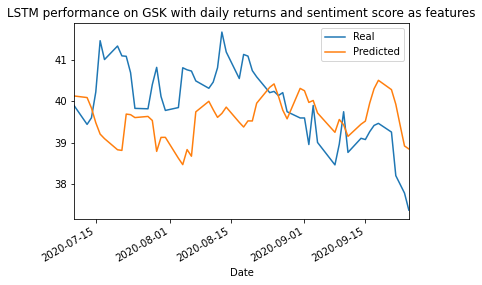

In [40]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="LSTM performance on GSK with daily returns and sentiment score as features")
plt.savefig('./Images/LSTMmodel_GSK_returns_sentiment.png')


## Predict Closing prices for AZN using LSTM

In [41]:
###AZN###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 0 is the 'Volume' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(azn_df, window_size, feature_column, target_column)

In [42]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [43]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [44]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.12375972]
  [0.        ]
  [0.02287014]]

 [[0.        ]
  [0.04077109]
  [0.01648876]]

 [[0.04077109]
  [0.03450662]
  [0.01633505]]] 

X_test sample values:
[[[0.0493022 ]
  [0.02266853]
  [0.06912602]]

 [[0.02266853]
  [0.06912602]
  [0.03113207]]

 [[0.06912602]
  [0.03113207]
  [0.05364267]]]


In [45]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [46]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [47]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 30)             3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [48]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 0.2704
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.1225
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0960
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1079
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0858
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0873
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1007
Epoch 8/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0853
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0841
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0931
Epoch 11/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0822
Epoch 12/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0858
Epoch 13/20
32/32 [==============================

In [49]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.1186


0.11862450838088989

In [50]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [51]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = azn_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,53.541969,57.914078
2020-07-13,53.333630,57.913933
2020-07-14,52.817760,57.914223
2020-07-15,53.551888,57.913883
2020-07-16,57.540005,57.913784


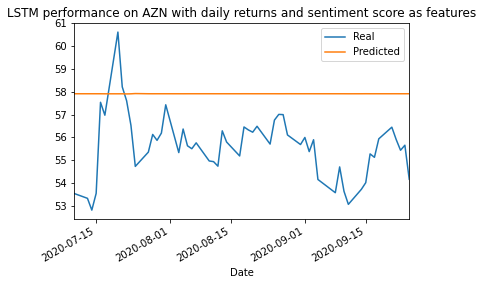

In [53]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="LSTM performance on AZN with daily returns and sentiment score as features")
plt.savefig('./Images/LSTMmodel_AZN_returns_sentiment.png')